In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

import os
os.environ["OMP_NUM_THREADS"] = "4"


In [314]:
class PredictiveCoding(nn.Module):
    def __init__(
        self,
        layer_dims=[1, 2, 2],
    ):
        super().__init__()

        self.layer_dims = layer_dims
        self.num_layers = len(self.layer_dims)


        # set the first layer weight to be [[0.0], [0.0]]
        self.layer1 = nn.Linear(self.layer_dims[0], self.layer_dims[1], bias=False)
        self.layer1.weight.data = torch.tensor([[0.0], [0.0]])
        # fix the second layer to be [(1, 0), (0, 2)]
        self.layer2 = nn.Parameter(torch.tensor([[1., 0.], [0., 2.]])).requires_grad_(False)
        

        self.E = 0  
        self.mu = nn.ParameterList([nn.Parameter(torch.ones(1, dim), requires_grad=(i not in [0, len(layer_dims) - 1])) for i, dim in enumerate(layer_dims)])
        self.error = [torch.zeros(1, dim) for dim in layer_dims]


    def clamp_input(self, input):
        # Explicitly set the first layer's mu to the input tensor
        self.mu[0].data = input.clone().detach().to(device)

    def clamp_output(self, output):
        # Explicitly set the last layer's mu to the output (target) tensor
        self.mu[-1].data = output.clone().detach().to(device)
        

    def compute_error(self):
        
        layer1_output = self.layer1(self.mu[0])
        self.error[1] = (self.mu[1] - layer1_output) 
        layer2_output = torch.mm(self.mu[1], self.layer2)
        self.error[2] = (self.mu[2] - layer2_output)
                
        self.E = torch.sum(torch.stack([torch.sum(0.5 * error ** 2) for error in self.error]))
        return self.E

    def output_pred(self, x):
        x = self.layer1(x)
        x = torch.mm(x, self.layer2)
        return x


In [315]:
def get_optimizer(parameters, optimizer_type, lr):
    if optimizer_type == "sgd":
        return optim.SGD(parameters, lr=lr)
    elif optimizer_type == "adam":
        return optim.Adam(parameters, lr=lr)
    elif optimizer_type == "adamw":
        return optim.AdamW(parameters, lr=lr)
    else:
        raise ValueError(f"Optimizer '{optimizer_type}' is not supported.")
    

def train_model(model, input, output, T=3, device="cpu", weight_optimizer_type = "sgd", mu_optimizer_type = "sgd", learning_rate=0.003):

    

    total_energy = 0
    weight_optimizer = get_optimizer(
        model.parameters(),
        weight_optimizer_type, 
        lr=learning_rate
    )

    input_pattern = input.to(device)
    target_pattern = output.to(device)

    # 
    # print(output)

    model.mu = nn.ParameterList([nn.Parameter(torch.zeros(1, dim).to(device), requires_grad=(i not in [0, len(model.layer_dims) - 1])) for i, dim in enumerate(model.layer_dims)])
    model.error = [torch.zeros(1, dim).to(device) for dim in model.layer_dims]
    model.clamp_input(input_pattern)
    model.clamp_output(target_pattern)


    mu_optimizer = get_optimizer(model.mu.parameters(),mu_optimizer_type,lr = 0.1)

    for t in range(T):
        energy = model.compute_error()
        
        mu_optimizer.zero_grad()
        energy.backward()
        mu_optimizer.step()

    energy = model.compute_error()


    weight_optimizer.zero_grad()
    energy.backward()
    weight_optimizer.step()

    energy = model.compute_error()     

    total_energy += energy

    tqdm.write(f"Total Energy: {total_energy:.4f}")

    prediction = model.output_pred(input_pattern)
    return model.layer1.weight, prediction





In [370]:
# training predictive coding model
import copy
batch_size = 128

num_epochs = 15
num_T = 60 # iteratioins of relaxation loop

mu_optimizer_type = "sgd" # Options: "sgd", "adam", "adamw"
weight_optimizer_type = "sgd" # Options: "sgd", "adam", "adamw"
learning_rate = 0.4 # learning rate for weight optimizer, learning rate for mu optimizer is set to 0.1


use_gpu = False # might not be faster on GPU due to small network size


# Define training data and target
input_data = torch.tensor([[1.0]])
target_data = torch.tensor([[1.0, 1.0]])

# best weight of layer 1: [[1, 0.5]]

model = PredictiveCoding(layer_dims=[1,2,2]) 

if use_gpu:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
else:
    device = torch.device("cpu")
print(f"Using device: {device}")
model.to(device)

weight_trajectory = []
prediction_trajectory = []

weight_trajectory.append(copy.deepcopy(model.layer1.weight).detach().cpu().numpy())
prediction_trajectory.append(model.output_pred(input_data).detach().cpu().numpy())

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    weight, prediction = train_model(model, input_data, target_data, T = num_T, device = device, weight_optimizer_type=weight_optimizer_type, mu_optimizer_type = mu_optimizer_type, learning_rate = learning_rate)

    weight_trajectory.append(copy.deepcopy(weight).detach().cpu().numpy())
    prediction_trajectory.append(prediction.detach().cpu().numpy())


print(weight_trajectory)
print(prediction_trajectory)

Using device: cpu
Epoch 1/15
Total Energy: 0.2188
Epoch 2/15
Total Energy: 0.1314
Epoch 3/15
Total Energy: 0.0801
Epoch 4/15
Total Energy: 0.0494
Epoch 5/15
Total Energy: 0.0308
Epoch 6/15
Total Energy: 0.0193
Epoch 7/15
Total Energy: 0.0122
Epoch 8/15
Total Energy: 0.0077
Epoch 9/15
Total Energy: 0.0049
Epoch 10/15
Total Energy: 0.0031
Epoch 11/15
Total Energy: 0.0020
Epoch 12/15
Total Energy: 0.0013
Epoch 13/15
Total Energy: 0.0008
Epoch 14/15
Total Energy: 0.0005
Epoch 15/15
Total Energy: 0.0003
[array([[0.],
       [0.]], dtype=float32), array([[0.19999969],
       [0.16      ]], dtype=float32), array([[0.3599994],
       [0.2688   ]], dtype=float32), array([[0.48799908],
       [0.342784  ]], dtype=float32), array([[0.5903988],
       [0.3930931]], dtype=float32), array([[0.6723185],
       [0.4273033]], dtype=float32), array([[0.7378543 ],
       [0.45056623]], dtype=float32), array([[0.7902829 ],
       [0.46638504]], dtype=float32), array([[0.8322258 ],
       [0.47714183]], dt

In [317]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

class SimpleNN(nn.Module):
    def __init__(self, input_dim = 1, hidden_dim = 2, output_dim = 2):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim,bias=False).requires_grad_(True)
        self.layer2 = nn.Linear(hidden_dim, output_dim,bias=False).requires_grad_(False)

        # initialize the weights
        self.layer1.weight.data = torch.tensor([[0.], [0.]])
        self.layer2.weight.data = torch.tensor([[1.0, 0.0], [0.0, 2.0]])

    
    
    def forward(self, x):
        x = (self.layer1(x))
        x = self.layer2(x)
        return x

In [318]:
def train_model_back(model, criterion, optimizer, inputs, targets, device):
    model.train()
    total_loss = 0

    inputs, targets = inputs.to(device), targets.to(device)
    
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    
    total_loss += loss.item()
    


In [371]:
import copy
from torch.utils.data import DataLoader, TensorDataset

# Hyperparameters
input_dim = 1
hidden_dim = 2
output_dim = 2
num_epochs = 15
learning_rate = 0.4
weight_optimizer_type = "sgd"  # Options: "sgd", "adam", "adamw"
use_gpu = False

# Data preparation
input_data = torch.tensor([[1.0]])
target_data = torch.tensor([[1.0, 1.0]])


# Model initialization
model_back = SimpleNN(input_dim, hidden_dim, output_dim)

device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
model_back.to(device)


# Optimizer and criterion
criterion = nn.MSELoss()
optimizer = get_optimizer(model_back.parameters(), weight_optimizer_type, lr=learning_rate)

# Training and testing loop
weight_trajectory_back = []
prediction_trajectory_back = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    

    weight_trajectory_back.append(copy.deepcopy(model_back.layer1.weight).detach().cpu().numpy())
    prediction_trajectory_back.append(model_back(input_data.to(device)).detach().cpu().numpy()) 
    
    train_model_back(model_back, criterion, optimizer, input_data, target_data, device)
    
    # Record weight and prediction trajectories for analysis
    weight_trajectory_back.append(copy.deepcopy(model_back.layer1.weight).detach().cpu().numpy())
    prediction_trajectory_back.append(model_back(input_data.to(device)).detach().cpu().numpy())

print(weight_trajectory_back)
print(prediction_trajectory_back)


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
[array([[0.],
       [0.]], dtype=float32), array([[0.4],
       [0.8]], dtype=float32), array([[0.4],
       [0.8]], dtype=float32), array([[0.64000005],
       [0.32      ]], dtype=float32), array([[0.64000005],
       [0.32      ]], dtype=float32), array([[0.78400004],
       [0.608     ]], dtype=float32), array([[0.78400004],
       [0.608     ]], dtype=float32), array([[0.8704],
       [0.4352]], dtype=float32), array([[0.8704],
       [0.4352]], dtype=float32), array([[0.92224],
       [0.53888]], dtype=float32), array([[0.92224],
       [0.53888]], dtype=float32), array([[0.953344],
       [0.476672]], dtype=float32), array([[0.953344],
       [0.476672]], dtype=float32), array([[0.9720064],
       [0.5139968]], dtype=float32), array([[0.9720064],
       [0.5139968]], dtype=float32), array([[0.9832038 ],
      

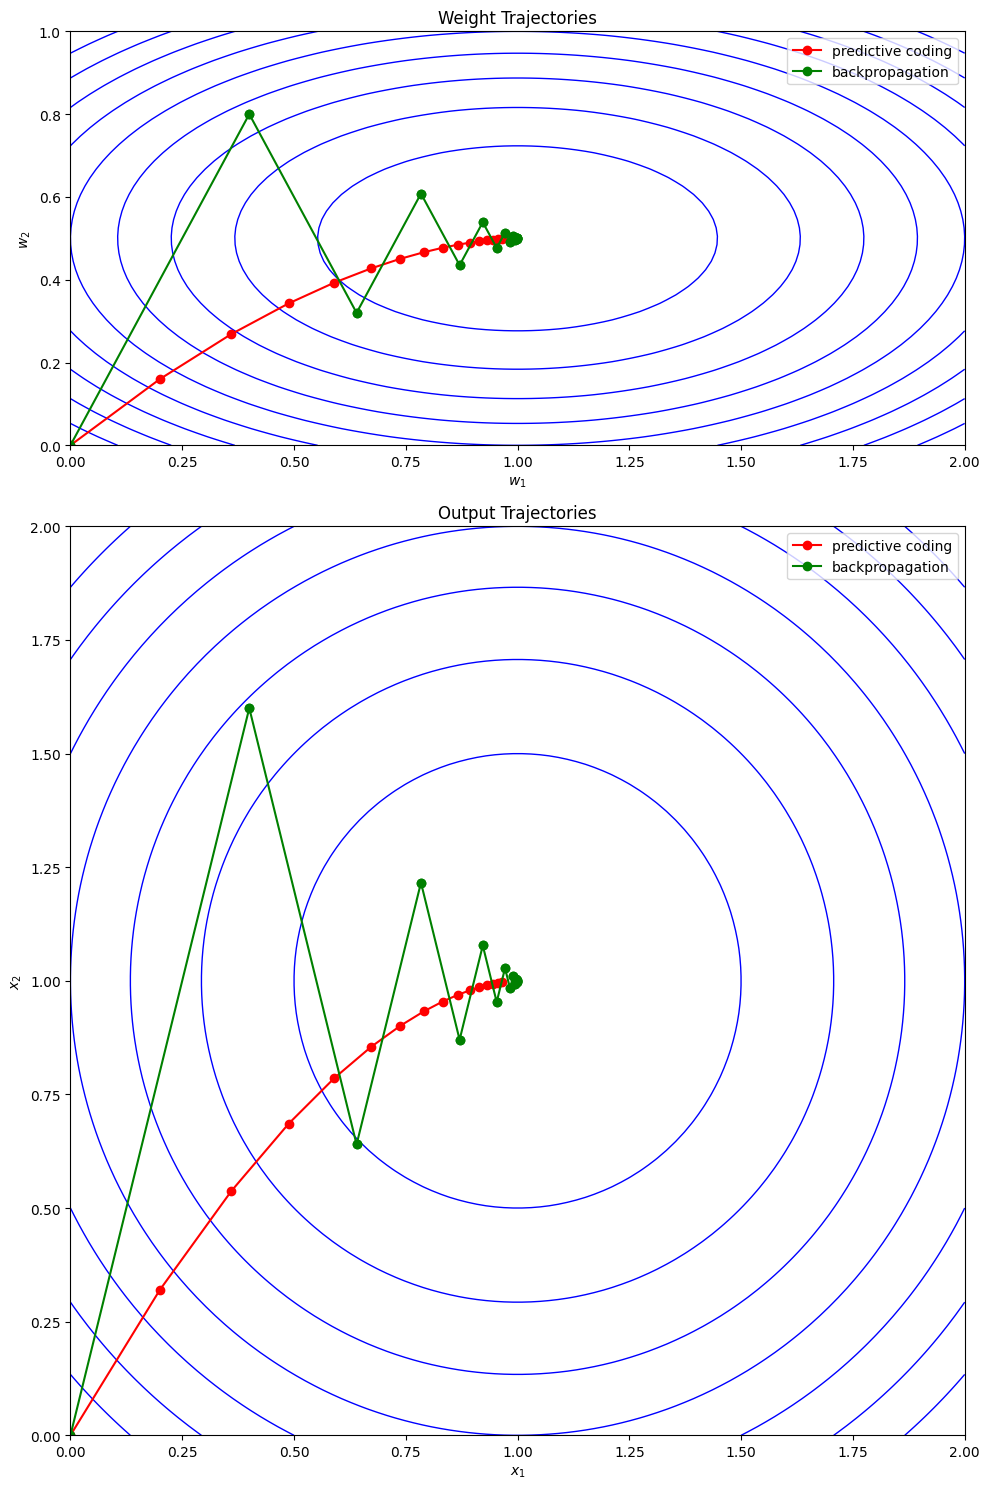

In [372]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec



# Define the function for the contour plot (e.g., a quadratic function)
def f2(x, y):
    return (x - 1)**2 + (y - 1)**2

def f1(x, y):
    return (x - 1)**2 + (2*y - 1)**2

# Generate grid data for contour plot
x = np.linspace(0, 2, 100)
y = np.linspace(0, 2, 100)

X, Y = np.meshgrid(x, y)
Z2 = f2(X, Y)
Z1 = f1(X, Y)

# Provided trajectory data
weight = weight_trajectory
weight_back = weight_trajectory_back

output = prediction_trajectory
output_back = prediction_trajectory_back

# Extract coordinates for weight trajectories
weight_x = [w[0, 0] for w in weight]
weight_y = [w[1, 0] for w in weight]
weight_x_back = [w[0, 0] for w in weight_back]
weight_y_back = [w[1, 0] for w in weight_back]

# Extract coordinates for output trajectories
output_x = [o[0, 0] for o in output]
output_y = [o[0, 1] for o in output]

output_x_back = [o[0, 0] for o in output_back]
output_y_back = [o[0, 1] for o in output_back]

# Create a figure and grid layout
fig = plt.figure(figsize=(10, 15))
gs = gridspec.GridSpec(5, 2)  # Create a 3x2 grid

# Create subplots with different sizes
ax0 = plt.subplot(gs[0:2, :])  # First subplot spanning the first row
ax1 = plt.subplot(gs[2:, :])  # Second subplot spanning the next two rows

axs = [ax0, ax1]

# Plot contours and trajectories for weight
axs[0].contour(X, Y, Z1, levels=64, linewidths=1, colors='blue')
axs[0].plot(weight_x, weight_y, 'ro-', label='predictive coding')
axs[0].plot(weight_x_back, weight_y_back, 'go-', label='backpropagation')
axs[0].set_title('Weight Trajectories')
axs[0].set_xlabel('$w_1$')
axs[0].set_ylabel('$w_2$')
axs[0].set_xlim(0, 2)
axs[0].set_ylim(0, 1)
axs[0].legend()

# Plot contours and trajectories for output
axs[1].contour(X, Y, Z2, levels=8, linewidths=1, colors='blue')
axs[1].plot(output_x, output_y, 'ro-', label='predictive coding')
axs[1].plot(output_x_back, output_y_back, 'go-', label='backpropagation')
axs[1].set_title('Output Trajectories')
axs[1].set_xlabel('$x_1$')
axs[1].set_ylabel('$x_2$')
axs[0].set_xlim(0, 2)
axs[0].set_ylim(0, 1)
axs[1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [339]:
# training predictive coding model
import copy
batch_size = 128

num_epochs = 150
num_T = 60 # iteratioins of relaxation loop

mu_optimizer_type = "sgd" # Options: "sgd", "adam", "adamw"
weight_optimizer_type = "sgd" # Options: "sgd", "adam", "adamw"
learning_rate = 0.05 # learning rate for weight optimizer, learning rate for mu optimizer is set to 0.1


use_gpu = False # might not be faster on GPU due to small network size


# Define training data and target
input_data = torch.tensor([[1.0]])
target_data = torch.tensor([[1.0, 1.0]])

# best weight of layer 1: [[1, 0.5]]

model_lower_learning_rate = PredictiveCoding(layer_dims=[1,2,2]) 

if use_gpu:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
else:
    device = torch.device("cpu")
print(f"Using device: {device}")
model_lower_learning_rate.to(device)

weight_trajectory_lower_learning_rate = []
prediction_trajectory_lower_learning_rate = []

weight_trajectory_lower_learning_rate.append(copy.deepcopy(model_lower_learning_rate.layer1.weight).detach().cpu().numpy())
prediction_trajectory_lower_learning_rate.append(model_lower_learning_rate.output_pred(input_data).detach().cpu().numpy())

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    train_model(model_lower_learning_rate, input_data, target_data, T = num_T, device = device, weight_optimizer_type=weight_optimizer_type, mu_optimizer_type = mu_optimizer_type, learning_rate = learning_rate)

    weight_trajectory_lower_learning_rate.append(copy.deepcopy(model_lower_learning_rate.layer1.weight).detach().cpu().numpy())
    prediction_trajectory_lower_learning_rate.append(model_lower_learning_rate.output_pred(input_data).detach().cpu().numpy())


print(weight_trajectory_lower_learning_rate)
print(prediction_trajectory_lower_learning_rate)

Using device: cpu
Epoch 1/150
Total Energy: 0.3300
Epoch 2/150
Total Energy: 0.3110
Epoch 3/150
Total Energy: 0.2932
Epoch 4/150
Total Energy: 0.2765
Epoch 5/150
Total Energy: 0.2607
Epoch 6/150
Total Energy: 0.2459
Epoch 7/150
Total Energy: 0.2320
Epoch 8/150
Total Energy: 0.2189
Epoch 9/150
Total Energy: 0.2066
Epoch 10/150
Total Energy: 0.1950
Epoch 11/150
Total Energy: 0.1841
Epoch 12/150
Total Energy: 0.1738
Epoch 13/150
Total Energy: 0.1641
Epoch 14/150
Total Energy: 0.1550
Epoch 15/150
Total Energy: 0.1464
Epoch 16/150
Total Energy: 0.1384
Epoch 17/150
Total Energy: 0.1307
Epoch 18/150
Total Energy: 0.1236
Epoch 19/150
Total Energy: 0.1168
Epoch 20/150
Total Energy: 0.1104
Epoch 21/150
Total Energy: 0.1044
Epoch 22/150
Total Energy: 0.0987
Epoch 23/150
Total Energy: 0.0934
Epoch 24/150
Total Energy: 0.0883
Epoch 25/150
Total Energy: 0.0835
Epoch 26/150
Total Energy: 0.0790
Epoch 27/150
Total Energy: 0.0748
Epoch 28/150
Total Energy: 0.0708
Epoch 29/150
Total Energy: 0.0670
Epoch

In [368]:
# training back propagation model
import copy
from torch.utils.data import DataLoader, TensorDataset

# Hyperparameters
input_dim = 1
hidden_dim = 2
output_dim = 2
num_epochs = 150
learning_rate = 0.05
weight_optimizer_type = "sgd"  # Options: "sgd", "adam", "adamw"
use_gpu = False

# Data preparation
input_data = torch.tensor([[1.0]])
target_data = torch.tensor([[1.0, 1.0]])


# Model initialization
model_back_lower_learning_rate = SimpleNN(input_dim, hidden_dim, output_dim)

device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
model_back_lower_learning_rate.to(device)


# Optimizer and criterion
criterion = nn.MSELoss()
optimizer = get_optimizer(model_back_lower_learning_rate.parameters(), weight_optimizer_type, lr=learning_rate)

# Training and testing loop
weight_trajectory_back_lower_learning_rate = []
prediction_trajectory_back_lower_learning_rate = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    

    weight_trajectory_back_lower_learning_rate.append(copy.deepcopy(model_back_lower_learning_rate.layer1.weight).detach().cpu().numpy())
    prediction_trajectory_back_lower_learning_rate.append(model_back_lower_learning_rate(input_data.to(device)).detach().cpu().numpy()) 
    
    train_model_back(model_back_lower_learning_rate, criterion, optimizer, input_data, target_data, device)
    
    # Record weight and prediction trajectories for analysis
    weight_trajectory_back_lower_learning_rate.append(copy.deepcopy(model_back_lower_learning_rate.layer1.weight).detach().cpu().numpy())
    prediction_trajectory_back_lower_learning_rate.append(model_back_lower_learning_rate(input_data.to(device)).detach().cpu().numpy())

print(weight_trajectory_back_lower_learning_rate)
print(prediction_trajectory_back_lower_learning_rate)


Epoch 1/150
Epoch 2/150
Epoch 3/150
Epoch 4/150
Epoch 5/150
Epoch 6/150
Epoch 7/150
Epoch 8/150
Epoch 9/150
Epoch 10/150
Epoch 11/150
Epoch 12/150
Epoch 13/150
Epoch 14/150
Epoch 15/150
Epoch 16/150
Epoch 17/150
Epoch 18/150
Epoch 19/150
Epoch 20/150
Epoch 21/150
Epoch 22/150
Epoch 23/150
Epoch 24/150
Epoch 25/150
Epoch 26/150
Epoch 27/150
Epoch 28/150
Epoch 29/150
Epoch 30/150
Epoch 31/150
Epoch 32/150
Epoch 33/150
Epoch 34/150
Epoch 35/150
Epoch 36/150
Epoch 37/150
Epoch 38/150
Epoch 39/150
Epoch 40/150
Epoch 41/150
Epoch 42/150
Epoch 43/150
Epoch 44/150
Epoch 45/150
Epoch 46/150
Epoch 47/150
Epoch 48/150
Epoch 49/150
Epoch 50/150
Epoch 51/150
Epoch 52/150
Epoch 53/150
Epoch 54/150
Epoch 55/150
Epoch 56/150
Epoch 57/150
Epoch 58/150
Epoch 59/150
Epoch 60/150
Epoch 61/150
Epoch 62/150
Epoch 63/150
Epoch 64/150
Epoch 65/150
Epoch 66/150
Epoch 67/150
Epoch 68/150
Epoch 69/150
Epoch 70/150
Epoch 71/150
Epoch 72/150
Epoch 73/150
Epoch 74/150
Epoch 75/150
Epoch 76/150
Epoch 77/150
Epoch 78

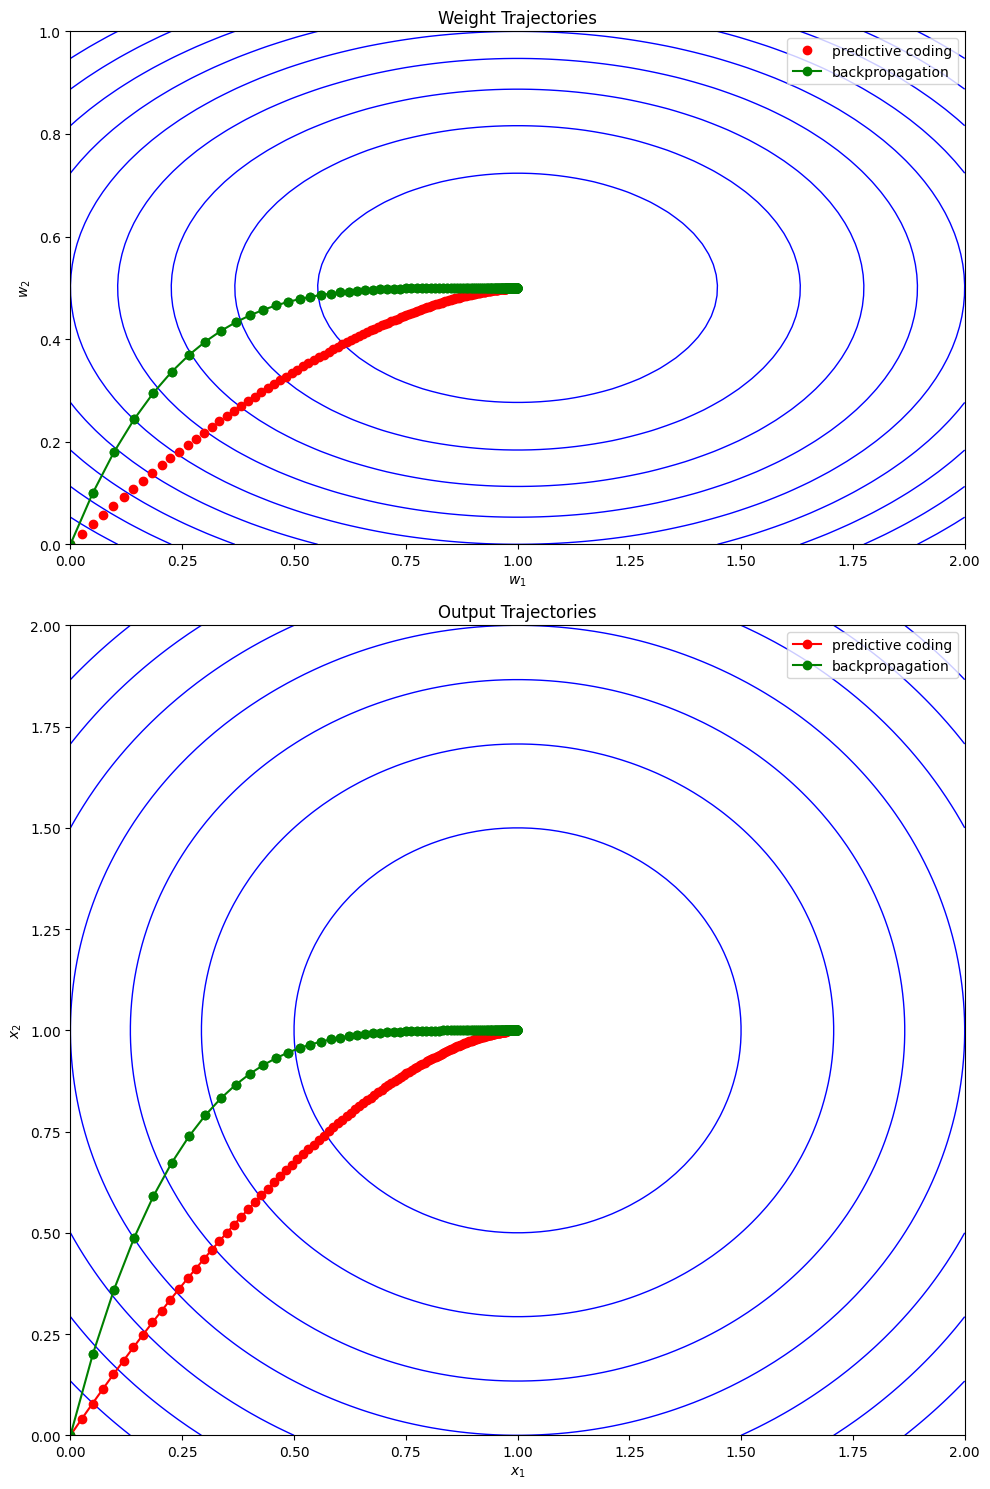

In [376]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


# Define the function for the contour plot (e.g., a quadratic function)
def f2(x, y):
    return (x - 1)**2 + (y - 1)**2

def f1(x, y):
    return (x - 1)**2 + (2*y - 1)**2

# Generate grid data for contour plot
x = np.linspace(0, 2, 100)
y = np.linspace(0, 2, 100)

X, Y = np.meshgrid(x, y)
Z2 = f2(X, Y)
Z1 = f1(X, Y)

# Provided trajectory data
weight = weight_trajectory_lower_learning_rate
weight_back = weight_trajectory_back_lower_learning_rate

output = prediction_trajectory_lower_learning_rate
output_back = prediction_trajectory_back_lower_learning_rate

# Extract coordinates for weight trajectories
weight_x = [w[0, 0] for w in weight]
weight_y = [w[1, 0] for w in weight]
weight_x_back = [w[0, 0] for w in weight_back]
weight_y_back = [w[1, 0] for w in weight_back]

# Extract coordinates for output trajectories
output_x = [o[0, 0] for o in output]
output_y = [o[0, 1] for o in output]

output_x_back = [o[0, 0] for o in output_back]
output_y_back = [o[0, 1] for o in output_back]

# Create a figure and grid layout
fig = plt.figure(figsize=(10, 15))
gs = gridspec.GridSpec(5, 2)  # Create a 3x2 grid

# Create subplots with different sizes
ax0 = plt.subplot(gs[0:2, :])  # First subplot spanning the first row
ax1 = plt.subplot(gs[2:, :])  # Second subplot spanning the next two rows

axs = [ax0, ax1]

# Plot contours and trajectories for weight
axs[0].contour(X, Y, Z1, levels=64, linewidths=1, colors='blue')
axs[0].plot(weight_x, weight_y, 'ro', label='predictive coding')
axs[0].plot(weight_x_back, weight_y_back, 'go-', label='backpropagation')
axs[0].set_title('Weight Trajectories')
axs[0].set_xlabel('$w_1$')
axs[0].set_ylabel('$w_2$')
axs[0].set_xlim(0, 2)
axs[0].set_ylim(0, 1)
axs[0].legend()

# Plot contours and trajectories for output
axs[1].contour(X, Y, Z2, levels=8, linewidths=1, colors='blue')
axs[1].plot(output_x, output_y, 'ro-', label='predictive coding')
axs[1].plot(output_x_back, output_y_back, 'go-', label='backpropagation')
axs[1].set_title('Output Trajectories')
axs[1].set_xlabel('$x_1$')
axs[1].set_ylabel('$x_2$')
axs[1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()
